# Portfolio Optimization with CVXPY - Fixed Version

This is a cleaned up version of po.ipynb with fixes for:
- Security issues (SSL certificate verification)
- Code bugs (variable shadowing, duplicate labels, bare exceptions)
- Code smells (unused imports, magic numbers, missing validation)
- Performance improvements (parallel processing enabled)

See [README.md](https://github.com/druce/portfolio_optimization/blob/master/README.md) for discussion, environment setup

In [37]:
# Core imports
import time
from multiprocessing import Pool

import numpy as np
import pandas as pd
import pandas_datareader as pdr

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import cvxpy as cp

# Set seed for reproducibility
np.random.seed(2347)

# Display versions
print(f"{'numpy':<20} {np.__version__}")
print(f"{'pandas':<20} {pd.__version__}")
print(f"{'pandas-datareader':<20} {pdr.__version__}")
print(f"{'seaborn':<20} {sns.__version__}")
print(f"{'matplotlib':<20} {matplotlib.__version__}")
print(f"{'cvxpy':<20} {cp.__version__}")

numpy                2.3.4
pandas               2.3.3
pandas-datareader    0.10.0
seaborn              0.13.2
matplotlib           3.10.7
cvxpy                1.7.3


# Configuration

In [38]:
# Data source configuration
DATA_XLS = 'https://www.stern.nyu.edu/~adamodar/pc/datasets/histretSP.xls'
DATA_SHEET = "Returns by year"

# Damodaran data structure constants (as of 2025)
DAMODARAN_HEADER_ROWS = 19  # Rows before data starts
DAMODARAN_FOOTER_ROWS = 13  # Footnote rows at end

# Manual GDP data for years not in FRED (source: fortunly.com)
MANUAL_GDP_DATA = {
    1928: 0.0110,
    1929: 0.0652,
}

# Optimization parameters
NPOINTS = 200  # Points on efficient frontier
USE_PARALLEL = False  # Enable parallel processing
NPROCESSES = 8  # Number of parallel processes

# Helper Functions

In [39]:
def fetch_with_retry(fetch_func, max_retries=3, delay=2):
    """
    Fetch data with retry logic for network resilience.
    
    Parameters
    ----------
    fetch_func : callable
        Function that fetches data
    max_retries : int
        Maximum number of retry attempts
    delay : int
        Delay in seconds between retries
    
    Returns
    -------
    Result from fetch_func
    """
    for attempt in range(max_retries):
        try:
            return fetch_func()
        except Exception as e:
            if attempt == max_retries - 1:
                raise
            print(f"Attempt {attempt + 1} failed: {e}. Retrying in {delay}s...")
            time.sleep(delay)


def validate_data(df, required_columns):
    """
    Validate DataFrame has required columns and no NaN/Inf values.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame to validate
    required_columns : list
        List of required column names
    
    Raises
    ------
    ValueError
        If validation fails
    """
    # Check for missing columns
    missing = set(required_columns) - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")
    
    # Check for NaN values
    if df[required_columns].isna().any().any():
        nan_cols = df[required_columns].columns[df[required_columns].isna().any()].tolist()
        print(f"Warning: NaN values found in columns: {nan_cols}")
        print(df[required_columns].isna().sum())
    
    # Check for infinite values
    if np.isinf(df[required_columns].values).any():
        raise ValueError("Infinite values found in data")


def solve_portfolio_optimization(params):
    """
    Solve portfolio optimization for given parameters.
    This is a standalone function that can be pickled for multiprocessing.
    
    Parameters
    ----------
    params : tuple
        (vl_val, mu, Sigma, n) where:
        - vl_val: volatility limit (variance)
        - mu: expected returns
        - Sigma: covariance matrix
        - n: number of assets
    
    Returns
    -------
    tuple
        (return, std_dev, weights)
    """
    vl_val, mu, Sigma, n = params
    
    # Create optimization variables and problem
    w = cp.Variable(n)
    ret = mu.T @ w
    vol = cp.quad_form(w, Sigma)
    
    prob = cp.Problem(
        cp.Maximize(ret),
        [cp.sum(w) == 1, w >= 0, vol <= vl_val]
    )
    
    result = prob.solve()
    
    if prob.status not in ['optimal', 'optimal_inaccurate']:
        print(f"Warning: Optimization returned status {prob.status} for vol_limit={vl_val}")
    
    return (ret.value, np.sqrt(vol.value), w.value.copy())


def add_historical_metrics(ret_df, df, asset_columns):
    """
    Add historical return and std columns based on actual portfolio performance.
    
    Computes what each efficient frontier portfolio would have actually returned
    historically, accounting for volatility drag and non-normal distributions.
    
    Parameters
    ----------
    ret_df : pd.DataFrame
        Efficient frontier results with model-based returns
    df : pd.DataFrame
        Historical returns data (same used for covariance computation)
    asset_columns : list or pd.Index
        Asset column names in order
    
    Returns
    -------
    pd.DataFrame
        ret_df with added hist_return and hist_std columns
    """
    hist_returns = []
    hist_stds = []
    
    for i in ret_df.index:
        # Extract portfolio weights for this efficient frontier point
        weights = np.array([ret_df.loc[i, col] for col in asset_columns])
        
        # Compute historical portfolio returns (time series of annual returns)
        portfolio_returns = df[asset_columns] @ weights
        
        # Geometric mean (compound annual growth rate)
        hist_return = (1 + portfolio_returns).prod() ** (1/len(portfolio_returns)) - 1
        
        # Historical standard deviation
        hist_std = portfolio_returns.std()
        
        hist_returns.append(hist_return)
        hist_stds.append(hist_std)
    
    ret_df['hist_return'] = hist_returns
    ret_df['hist_std'] = hist_stds
    
    return ret_df

# Get Data

In [40]:
# Load spreadsheet from Damodaran website
# Note: SSL certificate verification is disabled only for this specific request
# This is a known issue with the Damodaran website

import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

download_df = fetch_with_retry(
    lambda: pd.read_excel(
        DATA_XLS,
        sheet_name=DATA_SHEET,
        skiprows=range(DAMODARAN_HEADER_ROWS),
        skipfooter=DAMODARAN_FOOTER_ROWS
    )
)

download_df

,Year,S&P 500 (includes dividends),US Small cap (bottom decile),3-month T.Bill,US T. Bond (10-year),Baa Corporate Bond,Real Estate,Gold*,S&P 500 (includes dividends)3,US Small cap (bottom decile) Cum Value,...,Gold,S&P 500 (includes dividends)3.1,US Small cap (bottom decile)22.1,3-month T.Bill4.1,US T. Bond5.1,Baa Corporate Bond2.1,Real Estate2.1,Gold2.1,Stocks minus T. Bills,Stocks minus T.Bonds
0,1928,0.438112,0.5991,0.030800,0.008355,0.032196,0.014911,0.000969,143.811155,1.599100e+02,...,0.012676,145.493158,161.780293,104.285615,102.014834,104.426798,102.678084,101.267624,0.412075,0.434783
1,1929,-0.082979,-0.4661,0.031600,0.042038,0.030179,-0.020568,-0.001452,131.877782,8.537595e+01,...,-0.007258,132.644508,85.872317,106.955564,105.685290,106.952789,99.981502,100.532660,-0.113913,-0.124291
2,1930,-0.251236,-0.5003,0.045500,0.045409,0.005398,-0.043000,0.000969,98.745288,4.266236e+01,...,0.069359,106.105182,45.842164,119.462059,118.033011,114.876878,102.219599,107.505474,-0.317010,-0.316913
3,1931,-0.438375,-0.4466,0.023100,-0.025589,-0.156808,-0.081505,-0.173850,55.457774,2.360935e+01,...,-0.088971,65.713662,27.975463,134.778649,126.829091,106.815001,103.534271,97.940557,-0.508887,-0.455197
4,1932,-0.086424,0.2049,0.010700,0.087903,0.235896,-0.104664,0.212778,50.664911,2.844691e+01,...,0.351646,66.908619,37.567287,151.818576,153.776732,147.128135,103.312182,132.380976,-0.108245,-0.194288
5,1933,0.499822,1.4834,0.009600,0.018553,0.129669,-0.038119,0.272595,75.988361,7.064505e+01,...,0.262955,99.590799,92.587823,152.114850,155.443119,164.946945,98.621145,167.191159,0.486508,0.477624
6,1934,-0.011886,0.2001,0.002783,0.079634,0.188164,0.029062,0.317509,75.085189,8.478112e+01,...,0.297844,96.938336,109.456220,150.261549,165.316943,193.058938,99.972547,216.988085,-0.014450,-0.090154
7,1935,0.467404,0.5318,0.001675,0.044720,0.133077,0.097658,0.004324,110.180323,1.298677e+02,...,-0.024787,138.124606,162.805189,146.150541,167.703916,212.410113,106.554960,211.609648,0.452230,0.410432
8,1936,0.319434,0.9282,0.001725,0.050179,0.113838,0.032186,0.000861,145.375676,2.504109e+02,...,-0.013437,179.642789,309.436366,144.311177,173.603094,233.210615,108.413327,208.766253,0.313170,0.265409
9,1937,-0.353367,-0.5328,0.002758,0.013791,-0.044162,0.025634,-0.002294,94.004668,1.169920e+02,...,-0.030008,112.936160,140.552878,140.689539,171.108525,216.719604,108.103710,202.501542,-0.346233,-0.356960


In [41]:
# Set index to year
download_df["Year"] = download_df["Year"].astype(int)
download_df.set_index("Year", inplace=True)
download_df

,S&P 500 (includes dividends),US Small cap (bottom decile),3-month T.Bill,US T. Bond (10-year),Baa Corporate Bond,Real Estate,Gold*,S&P 500 (includes dividends)3,US Small cap (bottom decile) Cum Value,3-month T.Bill4,...,Gold,S&P 500 (includes dividends)3.1,US Small cap (bottom decile)22.1,3-month T.Bill4.1,US T. Bond5.1,Baa Corporate Bond2.1,Real Estate2.1,Gold2.1,Stocks minus T. Bills,Stocks minus T.Bonds
Year,,,,,,,,,,,,,,,,,,,,,
1928,0.438112,0.5991,0.030800,0.008355,0.032196,0.014911,0.000969,143.811155,1.599100e+02,103.080000,...,0.012676,145.493158,161.780293,104.285615,102.014834,104.426798,102.678084,101.267624,0.412075,0.434783
1929,-0.082979,-0.4661,0.031600,0.042038,0.030179,-0.020568,-0.001452,131.877782,8.537595e+01,106.337328,...,-0.007258,132.644508,85.872317,106.955564,105.685290,106.952789,99.981502,100.532660,-0.113913,-0.124291
1930,-0.251236,-0.5003,0.045500,0.045409,0.005398,-0.043000,0.000969,98.745288,4.266236e+01,111.175676,...,0.069359,106.105182,45.842164,119.462059,118.033011,114.876878,102.219599,107.505474,-0.317010,-0.316913
1931,-0.438375,-0.4466,0.023100,-0.025589,-0.156808,-0.081505,-0.173850,55.457774,2.360935e+01,113.743835,...,-0.088971,65.713662,27.975463,134.778649,126.829091,106.815001,103.534271,97.940557,-0.508887,-0.455197
1932,-0.086424,0.2049,0.010700,0.087903,0.235896,-0.104664,0.212778,50.664911,2.844691e+01,114.960894,...,0.351646,66.908619,37.567287,151.818576,153.776732,147.128135,103.312182,132.380976,-0.108245,-0.194288
1933,0.499822,1.4834,0.009600,0.018553,0.129669,-0.038119,0.272595,75.988361,7.064505e+01,116.064518,...,0.262955,99.590799,92.587823,152.114850,155.443119,164.946945,98.621145,167.191159,0.486508,0.477624
1934,-0.011886,0.2001,0.002783,0.079634,0.188164,0.029062,0.317509,75.085189,8.478112e+01,116.387564,...,0.297844,96.938336,109.456220,150.261549,165.316943,193.058938,99.972547,216.988085,-0.014450,-0.090154
1935,0.467404,0.5318,0.001675,0.044720,0.133077,0.097658,0.004324,110.180323,1.298677e+02,116.582514,...,-0.024787,138.124606,162.805189,146.150541,167.703916,212.410113,106.554960,211.609648,0.452230,0.410432
1936,0.319434,0.9282,0.001725,0.050179,0.113838,0.032186,0.000861,145.375676,2.504109e+02,116.783618,...,-0.013437,179.642789,309.436366,144.311177,173.603094,233.210615,108.413327,208.766253,0.313170,0.265409


In [42]:
# Download GDP data from FRED
gdp_download = fetch_with_retry(
    lambda: pdr.data.DataReader(['GDPCA'], 'fred', start='1926-12-31')
)

gdp_download.reset_index(inplace=True)
gdp_download.set_index(pd.DatetimeIndex(gdp_download['DATE']).year, inplace=True)
gdp_download['GDP'] = gdp_download['GDPCA'].pct_change()

# Fill in manual GDP data for early years
for year, value in MANUAL_GDP_DATA.items():
    gdp_download.loc[year, 'GDP'] = value

gdp_download.sort_index(inplace=True)
gdp_download.to_csv('gdp_fred.csv')

gdp_download

,DATE,GDPCA,GDP
DATE,,,
1928,NaT,NaN,0.011000
1929,1929-01-01,1191.124,0.065200
1930,1930-01-01,1089.785,-0.085078
1931,1931-01-01,1019.977,-0.064057
1932,1932-01-01,888.414,-0.128986
1933,1933-01-01,877.431,-0.012362
1934,1934-01-01,972.263,0.108079
1935,1935-01-01,1058.836,0.089043
1936,1936-01-01,1195.251,0.128835


In [43]:
# Preview columns
print("Available columns:")
for col in download_df.columns:
    print(f"  {col}")

Available columns:
  S&P 500 (includes dividends)
  US Small cap (bottom decile)
  3-month T.Bill
  US T. Bond (10-year)
   Baa Corporate Bond
  Real Estate
  Gold*
  S&P 500 (includes dividends)3
  US Small cap (bottom decile) Cum Value
  3-month T.Bill4
  US T. Bond5
   Baa Corporate Bond2
  Real Estate2
  Gold2
  Stocks - Bills
  Stocks - Bonds
  Small Cap Premium (S&P 500 minus Bottom Decile)
  Stocks - Baa Corp Bond
  Historical ERP
  Inflation Rate
  S&P 500 (includes dividends)2
  US Small cap (bottom decile)22
  3-month T. Bill (Real)
  !0-year T.Bonds
  Baa Corp Bonds
  Real Estate3
  Gold
  S&P 500 (includes dividends)3.1
  US Small cap (bottom decile)22.1
  3-month T.Bill4.1
  US T. Bond5.1
   Baa Corporate Bond2.1
  Real Estate2.1
  Gold2.1
  Stocks minus T. Bills
  Stocks minus T.Bonds


In [44]:
# Extract and rename columns to get real returns
# Note: Column names may have typos in source (e.g., '!0-year' instead of '10-year')

real_data_df = download_df.copy()

# Drop nominal real estate column
if "Real Estate" in real_data_df.columns:
    real_data_df = real_data_df.drop(columns=["Real Estate"])

# Define column rename mapping
rename_map = {
    'Inflation Rate': 'CPI',
    'S&P 500 (includes dividends)2': 'S&P',
    "US Small cap (bottom decile)22": "Small Caps",
    '3-month T. Bill (Real)': 'T-Bills',
    'Baa Corp Bonds': 'Baa Corps',
    'Real Estate3': 'Real Estate',
}

# Handle T-Bonds column (may have typo in source)
if '!0-year T.Bonds' in real_data_df.columns:
    rename_map['!0-year T.Bonds'] = 'T-Notes'
else:
    raise ValueError("Cannot find T-Bond column in source data")

real_data_df = real_data_df.rename(columns=rename_map)

# Add GDP data
real_data_df["GDP"] = gdp_download['GDP']

# Select and reorder columns
required_columns = ['GDP', 'CPI', 'S&P', 'Small Caps', 'T-Bills',
                   'T-Notes', 'Baa Corps', 'Real Estate', 'Gold']

validate_data(real_data_df, required_columns)
real_data_df = real_data_df[required_columns]

real_data_df

,GDP,CPI,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
Year,,,,,,,,,
1928,0.011000,-0.011561,0.454932,0.617803,0.042856,0.020148,0.044268,0.026781,0.012676
1929,0.065200,0.005848,-0.088311,-0.469204,0.025602,0.035980,0.024189,-0.026262,-0.007258
1930,-0.085078,-0.063953,-0.200079,-0.466159,0.116932,0.116835,0.074090,0.022385,0.069359
1931,-0.064057,-0.093168,-0.380674,-0.389744,0.128213,0.074522,-0.070178,0.012861,-0.088971
1932,-0.128986,-0.102740,0.018184,0.342866,0.126429,0.212472,0.377411,-0.002145,0.351646
1933,-0.012362,0.007634,0.488460,1.464586,0.001952,0.010836,0.121111,-0.045406,0.262955
1934,0.108079,0.015152,-0.026634,0.182188,-0.012184,0.063520,0.170431,0.013703,0.297844
1935,0.089043,0.029851,0.424871,0.487400,-0.027359,0.014439,0.100235,0.065842,-0.024787
1936,0.128835,0.014493,0.300585,0.900654,-0.012585,0.035176,0.097926,0.017440,-0.013437


In [45]:
# Compute geometric mean returns
cumreturns = (1 + real_data_df.copy()).cumprod()
geometric_mean = (cumreturns.iloc[-1] - 1) ** (1 / len(cumreturns)) - 1
print("Geometric mean returns:")
geometric_mean

Geometric mean returns:


GDP            0.031429
CPI            0.029775
S&P            0.066980
Small Caps     0.084076
T-Bills       -0.012478
T-Notes        0.011143
Baa Corps      0.034425
Real Estate    0.007420
Gold           0.018543
Name: 2024, dtype: float64

# Visualize

In [46]:
pd.set_option('display.max_rows', None)

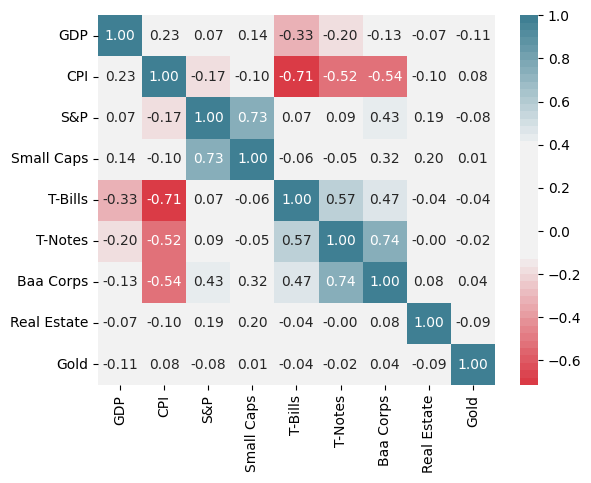

In [47]:
# Convert to float and compute correlation matrix
real_data_df = real_data_df.astype(float)

my_cmap = sns.diverging_palette(10, 220, sep=80, n=50)
sns.heatmap(real_data_df.corr(), annot=True, fmt=".02f", cmap=my_cmap);

In [48]:
# Drop CPI and GDP - these are not investable assets
try:
    real_data_df.drop(labels=['CPI', 'GDP'], axis=1, inplace=True)
except KeyError:
    pass  # Already dropped
    
df = real_data_df.copy()
df.head()

,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
Year,,,,,,,
1928,0.454932,0.617803,0.042856,0.020148,0.044268,0.026781,0.012676
1929,-0.088311,-0.469204,0.025602,0.035980,0.024189,-0.026262,-0.007258
1930,-0.200079,-0.466159,0.116932,0.116835,0.074090,0.022385,0.069359
1931,-0.380674,-0.389744,0.128213,0.074522,-0.070178,0.012861,-0.088971
1932,0.018184,0.342866,0.126429,0.212472,0.377411,-0.002145,0.351646


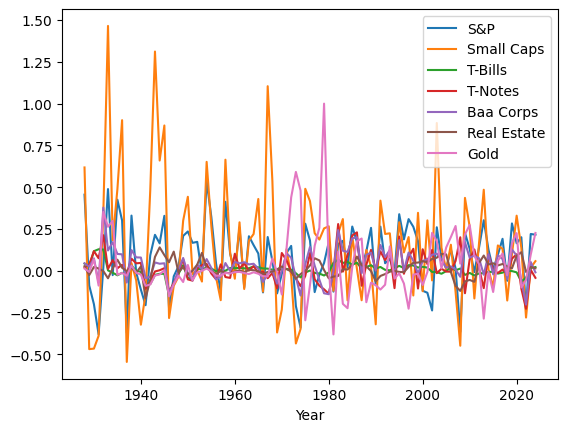

In [49]:
# Plot return series
df.plot.line();

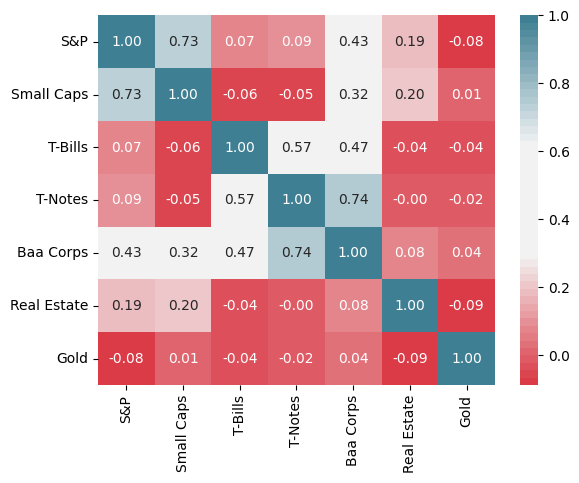

In [50]:
# Compute asset correlation matrix
my_cmap = sns.diverging_palette(10, 220, sep=80, n=50)
sns.heatmap(df.corr(), annot=True, fmt=".02f", cmap=my_cmap);

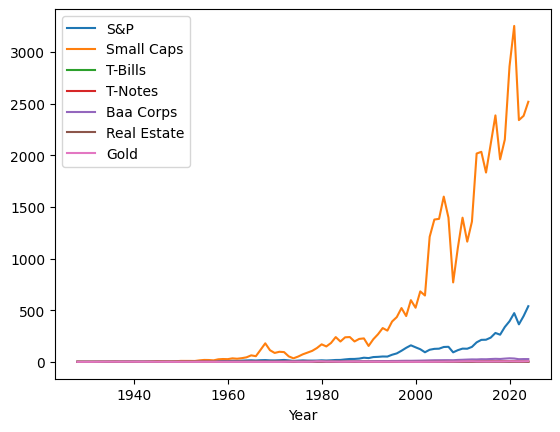

In [51]:
# Plot historical cumulative growth
df_cumulative = (1 + df.copy()).cumprod()
df_cumulative.plot.line();

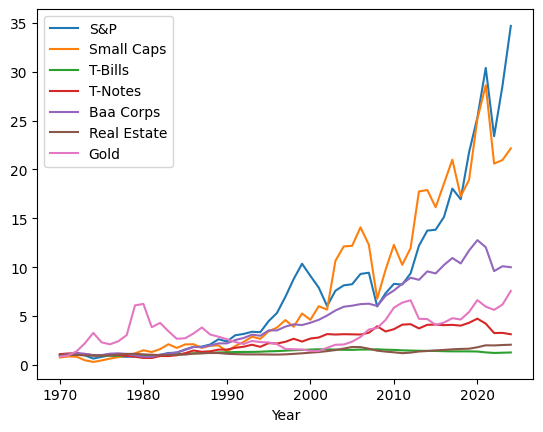

In [52]:
# Plot historical cumulative growth since 1970
df_cumulative_1970 = (1 + df.copy().loc[1970:]).cumprod()
df_cumulative_1970.plot.line();

In [53]:
labels = list(df.columns)
labels

['S&P', 'Small Caps', 'T-Bills', 'T-Notes', 'Baa Corps', 'Real Estate', 'Gold']

# Long-only Optimization

## 1928 - present

In [54]:
# Arithmetic means
df.mean()

S&P            0.085485
Small Caps     0.141127
T-Bills        0.003392
T-Notes        0.018030
Baa Corps      0.038531
Real Estate    0.012791
Gold           0.034768
dtype: float64

In [55]:
# Geometric mean
cumreturns = (1 + df.copy()).cumprod()
geometric_mean = (cumreturns.iloc[-1] - 1) ** (1 / len(cumreturns)) - 1
geometric_mean
# Note: Difference between arithmetic and geometric mean due to volatility drag

S&P            0.066980
Small Caps     0.084076
T-Bills       -0.012478
T-Notes        0.011143
Baa Corps      0.034425
Real Estate    0.007420
Gold           0.018543
Name: 2024, dtype: float64

In [56]:
# Compute covariance matrix and optimization parameters
Sigma = np.cov(df.transpose())
n = Sigma.shape[0]
mu = df.mean().values
asset_vols = np.sqrt(Sigma.diagonal())

# Display summary
summary_df = pd.DataFrame([mu, asset_vols], columns=labels)
summary_df['metric'] = ['real return', 'volatility']
summary_df.set_index('metric')

,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
metric,,,,,,,
real return,0.085485,0.141127,0.003392,0.018030,0.038531,0.012791,0.034768
volatility,0.193954,0.372102,0.038017,0.088987,0.088440,0.049934,0.186131


In [57]:
# Solve max return portfolio (corner solution)
w = cp.Variable(n)
ret = mu.T @ w
vol = cp.quad_form(w, Sigma)

prob = cp.Problem(
    cp.Maximize(ret),
    [cp.sum(w) == 1, w >= 0]
)
prob.solve()

if prob.status not in ['optimal', 'optimal_inaccurate']:
    raise ValueError(f"Optimization failed with status: {prob.status}")

wts = [float(f'{v:.4f}') for v in w.value]
maxretvol = vol.value
maxret = ret.value

print("Max return portfolio weights:")
pd.DataFrame([wts], columns=labels)

Max return portfolio weights:


,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [58]:
# Solve min volatility portfolio (other corner solution)
prob = cp.Problem(
    cp.Minimize(vol),
    [cp.sum(w) == 1, w >= 0]
)
prob.solve()

if prob.status not in ['optimal', 'optimal_inaccurate']:
    raise ValueError(f"Optimization failed with status: {prob.status}")

wts = [float(f'{v:.6f}') for v in w.value]
minvol = vol.value
minvolret = ret.value

print("Min volatility portfolio weights:")
pd.DataFrame([wts], columns=labels)

Min volatility portfolio weights:


,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
0,-0.0,0.00006,0.60004,-0.0,-0.0,0.36306,0.03684


In [59]:
%%time
# Solve efficient frontier
# For each volatility level between min and max, maximize return

# Generate volatility limits (linear in std dev space, squared for variance)
vl_vals = np.linspace(np.sqrt(minvol), np.sqrt(maxretvol), NPOINTS)
vl_vals = np.square(vl_vals)

# Prepare parameters for parallel processing
params_list = [(vl_val, mu, Sigma, n) for vl_val in vl_vals]

# Solve in parallel or serial
if USE_PARALLEL:
    with Pool(processes=NPROCESSES) as pool:
        result_values = pool.map(solve_portfolio_optimization, params_list)
    results_dict = dict(zip(vl_vals, result_values))
else:
    results_dict = {}
    for params in params_list:
        vl_val = params[0]
        results_dict[vl_val] = solve_portfolio_optimization(params)

CPU times: user 472 ms, sys: 12.1 ms, total: 484 ms
Wall time: 511 ms


In [60]:
# Build results DataFrame
ret_df = pd.DataFrame(enumerate(results_dict.keys()))
ret_df.columns = ['i', 'vol']
ret_df['return'] = [results_dict[v][0] for v in ret_df['vol']]
ret_df['std'] = [results_dict[v][1] for v in ret_df['vol']]

for i, colname in enumerate(labels):
    ret_df[colname] = [results_dict[v][2][i] for v in ret_df['vol']]

# Add historical metrics
ret_df = add_historical_metrics(ret_df, df, labels)

ret_df

,i,vol,return,std,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold,hist_return,hist_std
0,0,0.000831,0.007969,0.028834,1.129631e-10,0.000061,6.000384e-01,9.711195e-12,1.086140e-11,3.630600e-01,3.684076e-02,0.007553,0.028834
1,1,0.000934,0.012704,0.030559,3.165724e-02,0.004561,5.104807e-01,1.735798e-08,2.448363e-02,3.745014e-01,5.431635e-02,0.012236,0.030559
2,2,0.001042,0.014972,0.032284,4.124258e-02,0.005536,4.564939e-01,7.770378e-08,5.566569e-02,3.805597e-01,6.050252e-02,0.014451,0.032284
3,3,0.001157,0.016821,0.034009,4.904997e-02,0.006332,4.124470e-01,9.902412e-08,8.111290e-02,3.855173e-01,6.554110e-02,0.016245,0.034009
4,4,0.001277,0.018454,0.035734,5.593083e-02,0.007043,3.735423e-01,1.926213e-07,1.035550e-01,3.899479e-01,6.998067e-02,0.017819,0.035734
5,5,0.001403,0.019950,0.037459,6.225712e-02,0.007681,3.379633e-01,3.562945e-07,1.241628e-01,3.938617e-01,7.407330e-02,0.019254,0.037459
6,6,0.001535,0.021353,0.039184,6.817221e-02,0.008288,3.045687e-01,5.960005e-07,1.434710e-01,3.976013e-01,7.789771e-02,0.020593,0.039184
7,7,0.001674,0.022687,0.040908,7.382565e-02,0.008860,2.727763e-01,7.382980e-08,1.617715e-01,4.012383e-01,8.152851e-02,0.021860,0.040908
8,8,0.001818,0.023968,0.042633,7.922720e-02,0.009412,2.422806e-01,5.663883e-08,1.794181e-01,4.046393e-01,8.502301e-02,0.023072,0.042633
9,9,0.001968,0.025207,0.044358,8.445824e-02,0.009947,2.127728e-01,9.259948e-08,1.964672e-01,4.079531e-01,8.840156e-02,0.024238,0.044358


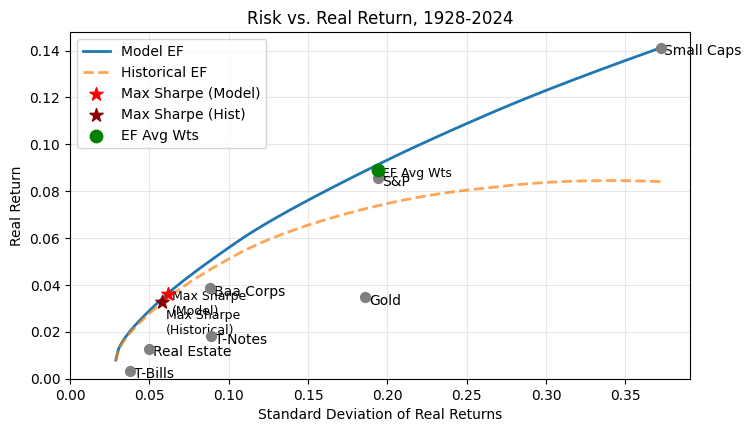

MODEL-BASED Max Sharpe Portfolio:
Real Return:  3.63%
SD:           6.16%
Sharpe Ratio: 0.590
Real Estate: 39.3%
Baa Corps: 33.3%
Gold: 11.9%
S&P: 13.6%
Small Caps: 1.9%

HISTORICAL Max Sharpe Portfolio:
Real Return:  3.26%
SD:           5.82%
Sharpe Ratio: 0.561
Real Estate: 43.0%
Baa Corps: 32.0%
Gold: 11.3%
S&P: 12.3%
Small Caps: 1.4%

Average over efficient frontier:
Real Return:  8.90%
SD:           19.42%
Sharpe Ratio: 0.458
T-Bills: 2.2%
Real Estate: 6.3%
Baa Corps: 12.8%
Gold: 9.2%
S&P: 32.4%
Small Caps: 37.1%


In [61]:
def plot_efrontier(ret_df, df, asset_vols, mu,
                   xlabel="Standard Deviation of Real Returns",
                   ylabel="Real Return",
                   title=None,
                   risk_free_rate=0,
                   show_historical=True):
    """
    Plot efficient frontier with individual assets and key portfolios.

    Parameters
    ----------
    ret_df : pd.DataFrame
        Efficient frontier results with columns: return, std, asset weights
    df : pd.DataFrame
        Historical returns data
    asset_vols : np.ndarray
        Standard deviations of individual assets
    mu : np.ndarray
        Expected returns of individual assets
    xlabel : str
        X-axis label
    ylabel : str
        Y-axis label
    title : str, optional
        Plot title (defaults to date range)
    risk_free_rate : float
        Risk-free rate for Sharpe ratio calculation
    show_historical : bool
        If True, plot historical frontier alongside model frontier

    Returns
    -------
    tuple
        (max_sharpe_return, max_sharpe_std, avg_ret_mean, avg_ret_std)
    """
    # Compute Sharpe ratios (model-based)
    ret_df["Sharpe"] = (ret_df["return"] - risk_free_rate) / ret_df["std"]
    
    # Find max Sharpe portfolio (model-based)
    max_sharpe_index = ret_df["Sharpe"].idxmax()
    max_sharpe_return = ret_df.loc[max_sharpe_index, "return"]
    max_sharpe_std = ret_df.loc[max_sharpe_index, "std"]
    max_sharpe_ratio = ret_df.loc[max_sharpe_index, "Sharpe"]
    
    # Compute historical Sharpe ratios if available
    if 'hist_return' in ret_df.columns and 'hist_std' in ret_df.columns:
        ret_df["hist_Sharpe"] = (ret_df["hist_return"] - risk_free_rate) / ret_df["hist_std"]
        max_hist_sharpe_index = ret_df["hist_Sharpe"].idxmax()
        max_hist_sharpe_return = ret_df.loc[max_hist_sharpe_index, "hist_return"]
        max_hist_sharpe_std = ret_df.loc[max_hist_sharpe_index, "hist_std"]
        max_hist_sharpe_ratio = ret_df.loc[max_hist_sharpe_index, "hist_Sharpe"]
    
    # Compute average efficient frontier portfolio
    asset_names = [t for t in ['TIPS', 'T-Bills', 'Real Estate', 'T-Notes', 
                               'Baa Corps', 'Gold', 'S&P', 'Small Caps'] 
                  if t in ret_df.columns]
    
    mean_wts = ret_df[asset_names].mean()
    avg_ret = df[asset_names] @ mean_wts.values
    avg_ret_mean = avg_ret.mean()
    avg_ret_std = avg_ret.std()
    
    # Create plot
    plt.figure(figsize=(8, 4.5))
    
    # Plot model-based efficient frontier
    plt.plot(ret_df['std'], ret_df['return'], label='Model EF', linewidth=2)
    
    # Plot historical efficient frontier if requested
    if show_historical and 'hist_return' in ret_df.columns:
        plt.plot(ret_df['hist_std'], ret_df['hist_return'], 
                label='Historical EF', linestyle='--', linewidth=2, alpha=0.7)
    
    plt.xlim(left=0, right=max(asset_vols) * 1.05)
    plt.ylim(bottom=min(0, min(mu)))
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plot_title = f"Risk vs. Real Return, {df.index[0]}-{df.index[-1]}" if title is None else title
    plt.title(plot_title)

    # Plot individual assets
    plt.scatter(asset_vols, mu, color='gray', s=50, zorder=5)
    xoffset = 0.0025
    yoffset = 0.0015
    asset_labels = df.columns
    for i, label in enumerate(asset_labels):
        plt.annotate(label, xy=(asset_vols[i] + xoffset, mu[i] + yoffset),
                    xycoords='data', horizontalalignment='left',
                    verticalalignment='top')
    
    # Plot max Sharpe portfolio (model)
    plt.scatter([max_sharpe_std], [max_sharpe_return], color='red', s=100, 
               marker='*', label='Max Sharpe (Model)', zorder=10)
    plt.annotate("Max Sharpe\n(Model)", xy=(max_sharpe_std + xoffset, max_sharpe_return + yoffset),
                xycoords='data', horizontalalignment='left',
                verticalalignment='top', fontsize=9)
    
    # Plot max Sharpe portfolio (historical) if available
    if show_historical and 'hist_return' in ret_df.columns:
        plt.scatter([max_hist_sharpe_std], [max_hist_sharpe_return], 
                   color='darkred', s=100, marker='*', 
                   label='Max Sharpe (Hist)', zorder=10)
        plt.annotate("Max Sharpe\n(Historical)", 
                    xy=(max_hist_sharpe_std + xoffset, max_hist_sharpe_return - yoffset*2),
                    xycoords='data', horizontalalignment='left',
                    verticalalignment='top', fontsize=9)
    
    # Plot average EF portfolio
    plt.scatter([avg_ret_std], [avg_ret_mean], color='green', s=80, 
               marker='o', label='EF Avg Wts', zorder=10)
    plt.annotate("EF Avg Wts", xy=(avg_ret_std + xoffset, avg_ret_mean + yoffset),
                xycoords='data', horizontalalignment='left',
                verticalalignment='top', fontsize=9)
    
    plt.legend(loc='best')
    plt.grid(alpha=0.3)
    plt.show()
    
    # Print statistics
    print("="*60)
    print("MODEL-BASED Max Sharpe Portfolio:")
    print(f"Real Return:  {100 * max_sharpe_return:3.2f}%")
    print(f"SD:           {100 * max_sharpe_std:3.2f}%")
    print(f"Sharpe Ratio: {max_sharpe_ratio:3.3f}")
    for col in asset_names:
        wt = ret_df.loc[max_sharpe_index, col]
        if wt > 0.001:  # Only show non-zero weights
            print(f"{col}: {100*wt:3.1f}%")
  
    if 'hist_return' in ret_df.columns:
        print()
        print("HISTORICAL Max Sharpe Portfolio:")
        print(f"Real Return:  {100 * max_hist_sharpe_return:3.2f}%")
        print(f"SD:           {100 * max_hist_sharpe_std:3.2f}%")
        print(f"Sharpe Ratio: {max_hist_sharpe_ratio:3.3f}")
        for col in asset_names:
            wt = ret_df.loc[max_hist_sharpe_index, col]
            if wt > 0.001:
                print(f"{col}: {100*wt:3.1f}%")
    
    print()
    print("Average over efficient frontier:")
    print(f"Real Return:  {100 * avg_ret_mean:3.2f}%")
    print(f"SD:           {100 * avg_ret_std:3.2f}%")
    print(f"Sharpe Ratio: {avg_ret_mean / avg_ret_std:3.3f}")
    for col in asset_names:
        wt = mean_wts[col]
        if wt > 0.001:
            print(f"{col}: {100*wt:3.1f}%")
    print("="*60)
    
    return max_sharpe_return, max_sharpe_std, avg_ret_mean, avg_ret_std


max_sharpe_return, max_sharpe_std, avg_ret_mean, avg_ret_std = plot_efrontier(
    ret_df, df, asset_vols, mu, show_historical=True
)

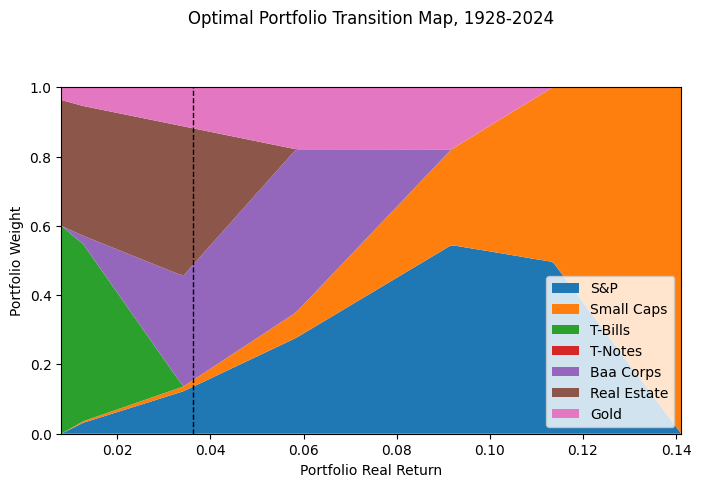

In [62]:
def transition_map(ret_df, asset_labels, startyear, endyear, 
                  max_sharpe_return=None, ylim=1):
    """
    Create transition map showing portfolio weights across return levels.
    
    Parameters
    ----------
    ret_df : pd.DataFrame
        Efficient frontier results
    asset_labels : list or pd.Index
        Asset names
    startyear : int
        Start year for title
    endyear : int
        End year for title
    max_sharpe_return : float, optional
        Return of max Sharpe portfolio (draws vertical line)
    ylim : float
        Y-axis limit
    """
    x = ret_df['return']
    y_list = [ret_df[label] for label in asset_labels]
    
    # Generate colors dynamically based on number of assets
    colors = cm.tab10.colors[:len(asset_labels)]
    
    fig = plt.figure(figsize=(8, 4.5))
    ax1 = fig.add_subplot(111)
  
    ax1.stackplot(x, y_list, labels=asset_labels, colors=colors)
    ax1.set_xlim((ret_df['return'].iloc[0], ret_df['return'].iloc[-1]))
    ax1.set_ylim((0, ylim))
    ax1.set_xlabel("Portfolio Real Return")
    ax1.set_ylabel("Portfolio Weight")
    ax1.legend(loc='lower right')
    
    if max_sharpe_return is not None:
        ax1.axvline(max_sharpe_return, color='black', linestyle='--', linewidth=1)
        
    plt.title(f"Optimal Portfolio Transition Map, {startyear}-{endyear}", y=1.16)
    plt.show()


transition_map(ret_df, asset_labels=df.columns, 
              startyear=df.index[0], endyear=df.index[-1],
              max_sharpe_return=max_sharpe_return)

## Add a Risk-Free Asset (TIPS)

- The efficient frontier above does not include a risk-free asset. When we inflation-adjust T-Bill returns, we get volatility and fluctuations including periods of negative real returns.
- TIPS (Treasury Inflation-Protected Securities) offer a guaranteed real pre-tax return. They are issued at a real rate, the principal gets adjusted for inflation, and you cannot get back less than par even with deflation.
- TIPS offer an inflation hedge and a safe real return. They may dominate gold for this purpose, as gold lacks a theoretical basis for outpacing inflation in the long run.
- TIPS total returns are only available for approximately the last 25 years. Modeling historical TIPS returns would require modeling inflation expectations.
- We posit that a risk-free 0% real yield TIPS asset is available (worst case scenario at 0% auction rate).
- Note: Real TIPS would have positive returns with some fluctuation, so this model may underweight TIPS.

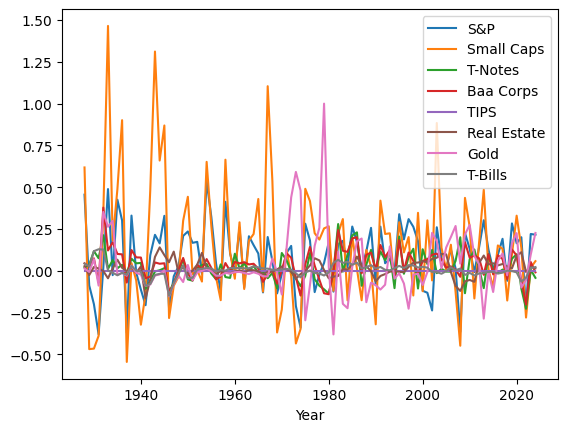

In [27]:
# Add TIPS as zero-return asset
df_tips = real_data_df.loc[1928:].copy()
df_tips["TIPS"] = 0.0

# Reorder for charts
df_tips = df_tips[['S&P', 'Small Caps', 'T-Notes', 'Baa Corps', 
                   'TIPS', 'Real Estate', 'Gold', 'T-Bills']]
labels_tips = df_tips.columns

df_tips.plot.line();

In [28]:
# Recompute optimization parameters with TIPS
Sigma_tips = np.cov(df_tips.transpose())
n_tips = Sigma_tips.shape[0]
mu_tips = df_tips.mean().values
asset_vols_tips = np.sqrt(Sigma_tips.diagonal())

summary_tips = pd.DataFrame([mu_tips, asset_vols_tips], columns=labels_tips)
summary_tips['metric'] = ['real return', 'volatility']
summary_tips.set_index('metric')

,S&P,Small Caps,T-Notes,Baa Corps,TIPS,Real Estate,Gold,T-Bills
metric,,,,,,,,
real return,0.085485,0.141127,0.018030,0.038531,0.0,0.012791,0.034768,0.003392
volatility,0.193954,0.372102,0.088987,0.088440,0.0,0.049934,0.186131,0.038017


In [29]:
# Max return portfolio with TIPS
w_tips = cp.Variable(n_tips)
ret_tips = mu_tips.T @ w_tips
vol_tips = cp.quad_form(w_tips, Sigma_tips)

prob_tips = cp.Problem(
    cp.Maximize(ret_tips),
    [cp.sum(w_tips) == 1, w_tips >= 0]
)
prob_tips.solve()

if prob_tips.status not in ['optimal', 'optimal_inaccurate']:
    raise ValueError(f"Optimization failed with status: {prob_tips.status}")

wts_tips = [float(f'{v:.4f}') for v in w_tips.value]
maxretvol_tips = vol_tips.value

print("Max return portfolio weights (with TIPS):")
pd.DataFrame([wts_tips], columns=labels_tips)

Max return portfolio weights (with TIPS):


,S&P,Small Caps,T-Notes,Baa Corps,TIPS,Real Estate,Gold,T-Bills
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# Min volatility portfolio with TIPS
prob_tips = cp.Problem(
    cp.Minimize(vol_tips),
    [cp.sum(w_tips) == 1, w_tips >= 0]
)
prob_tips.solve()

if prob_tips.status not in ['optimal', 'optimal_inaccurate']:
    raise ValueError(f"Optimization failed with status: {prob_tips.status}")

wts_tips = [float(f'{v:.6f}') for v in w_tips.value]
minvol_tips = vol_tips.value

print("Min volatility portfolio weights (with TIPS):")
pd.DataFrame([wts_tips], columns=labels_tips)

Min volatility portfolio weights (with TIPS):


,S&P,Small Caps,T-Notes,Baa Corps,TIPS,Real Estate,Gold,T-Bills
0,-0.0,-0.0,0.0,0.0,1.0,-0.0,0.0,0.0


In [31]:
%%time
# Solve efficient frontier with TIPS

vl_vals_tips = np.linspace(np.sqrt(minvol_tips), np.sqrt(maxretvol_tips), NPOINTS)
vl_vals_tips = np.square(vl_vals_tips)

# Prepare parameters for parallel processing
params_list_tips = [(vl_val, mu_tips, Sigma_tips, n_tips) for vl_val in vl_vals_tips]

if USE_PARALLEL:
    with Pool(processes=NPROCESSES) as pool:
        result_values_tips = pool.map(solve_portfolio_optimization, params_list_tips)
    results_dict_tips = dict(zip(vl_vals_tips, result_values_tips))
else:
    results_dict_tips = {}
    for params in params_list_tips:
        vl_val = params[0]
        results_dict_tips[vl_val] = solve_portfolio_optimization(params)

/opt/anaconda3/envs/portfolio_optimization/lib/python3.11/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


CPU times: user 445 ms, sys: 5.22 ms, total: 451 ms
Wall time: 530 ms


In [ ]:
# Build results DataFrame with TIPS
ret_df_tips = pd.DataFrame(enumerate(results_dict_tips.keys()))
ret_df_tips.columns = ['i', 'vol']
ret_df_tips['return'] = [results_dict_tips[v][0] for v in ret_df_tips['vol']]
ret_df_tips['std'] = [results_dict_tips[v][1] for v in ret_df_tips['vol']]

for i, colname in enumerate(labels_tips):
    ret_df_tips[colname] = [results_dict_tips[v][2][i] for v in ret_df_tips['vol']]

# Add historical metrics
ret_df_tips = add_historical_metrics(ret_df_tips, df_tips, labels_tips)

ret_df_tips

In [ ]:
max_sharpe_return_tips, max_sharpe_std_tips, avg_ret_mean_tips, avg_ret_std_tips = plot_efrontier(
    ret_df_tips, df_tips, asset_vols_tips, mu_tips, show_historical=True
)

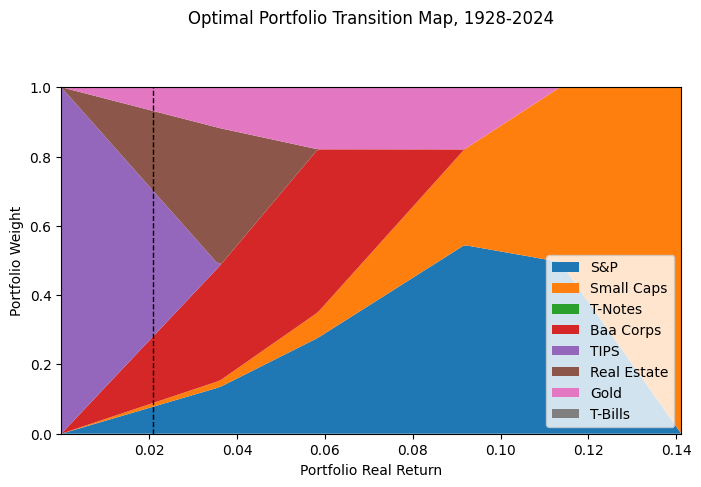

In [34]:
transition_map(ret_df_tips, asset_labels=df_tips.columns,
              startyear=df_tips.index[0], endyear=df_tips.index[-1],
              max_sharpe_return=max_sharpe_return_tips)

In [35]:
# Regularization: average weights across all efficient frontier portfolios
# This provides a more robust allocation less sensitive to estimation error
regularized = ret_df_tips[['S&P', 'Small Caps', 'T-Notes', 'Baa Corps', 
                           'TIPS', 'Real Estate', 'Gold', 'T-Bills']].mean()

print("Regularized portfolio (average of all efficient portfolios):")
with pd.option_context('display.float_format', '{:.6f}'.format):
    display(regularized)

Regularized portfolio (average of all efficient portfolios):


S&P           0.302268
Small Caps    0.342728
T-Notes       0.000000
Baa Corps     0.128582
TIPS          0.084263
Real Estate   0.055140
Gold          0.087019
T-Bills       0.000000
dtype: float64

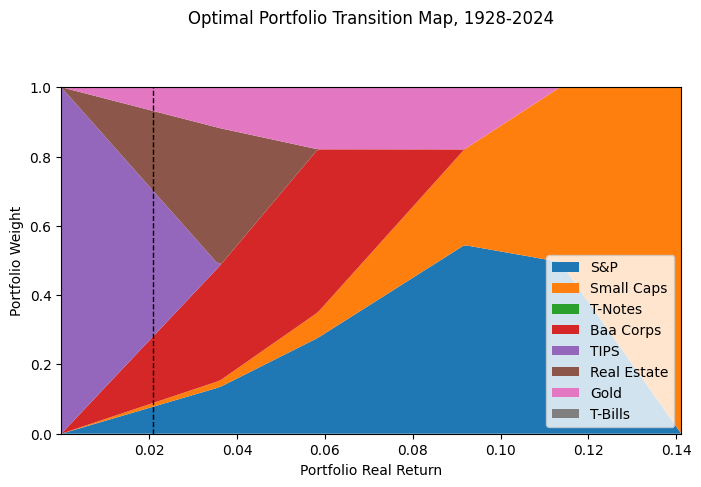

In [36]:
# Note: This notebook only includes long-only portfolios
# For long-short analysis with leverage, see Portfolio optimization.ipynb
transition_map(ret_df_tips, asset_labels=df_tips.columns,
              startyear=df_tips.index[0], endyear=df_tips.index[-1],
              max_sharpe_return=max_sharpe_return_tips,
              ylim=1.0)